# habits before G@C of those who are participating in G@C found from survey

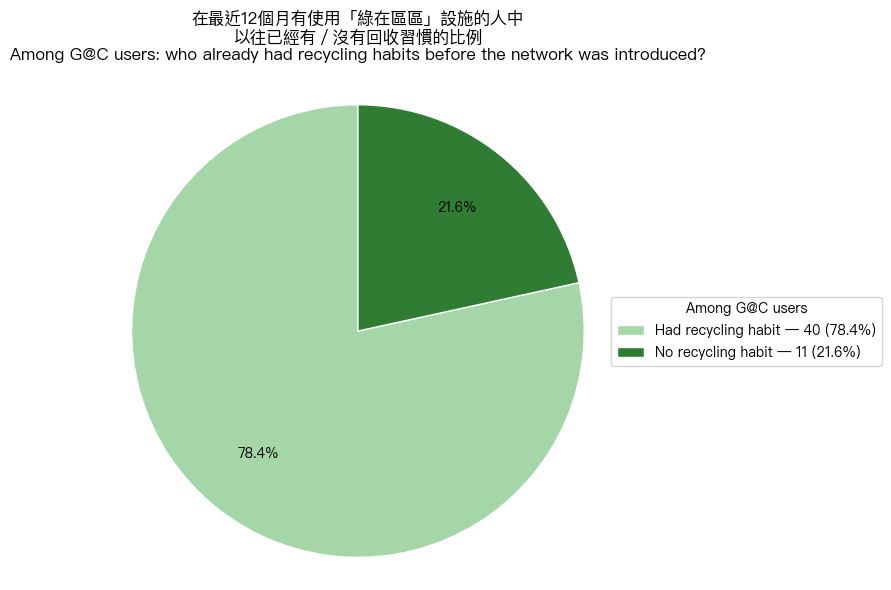

In [1]:
# ------------------------------------------------------------
# Pie chart:
# 「在最近12個月內有使用『綠在區區』設施的人之中，
#  有多少人於設立前已經有回收習慣？」
# "Among G@C users, how many already had recycling habits
#  before the Green@Community network?"
#
# How to run (1.2 .ipynb / VS Code):
#   - Make sure ../GCAP3226 G@C Survey Responses_cleaned data.xlsx exists
#   - Run this cell / script; it will ONLY show the pie chart
# ------------------------------------------------------------

# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns by question text ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    # try explicit regex patterns first
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# ---------- locate "used G@C in the past 12 months" column ----------
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]
use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'used G@C in past 12 months' column.")

use_series = df[use_col].astype(str)

# map Yes / No
def used_gc(text):
    s = str(text).strip().lower()
    if s in {"yes", "y", "是", "有"}:
        return True
    if s in {"no", "n", "否", "沒有", "未有", "無"}:
        return False
    return None

use_flags = use_series.map(used_gc)

# keep only respondents who HAVE used G@C
mask_users = use_flags == True
df_users = df[mask_users]

# ---------- locate "recycling habit before G@C" column ----------
habit_patterns = [
    r"before\s+the\s+green@community\s+recycling\s+network\s+was\s+introduced.*recycling\s+habit",
    r"在未有.*綠在區區.*回收網絡前.*是否有回收習慣",
]
habit_col = find_col(df.columns, habit_patterns)
if habit_col is None:
    raise RuntimeError("Could not find the 'recycling habit before G@C' column.")

habit_series = df_users[habit_col].astype(str)

# ---------- classify habits ----------
def habit_category(text):
    s = str(text).strip().lower()
    if s.startswith("yes"):
        return "Had recycling habit"
    if s.startswith("no"):
        return "No recycling habit"
    return "Unknown"

habit_cat = habit_series.map(habit_category)

# counts among G@C users
counts_raw = habit_cat.value_counts().to_dict()

# keep only categories that actually appear
labels_all = ["Had recycling habit", "No recycling habit", "Unknown"]
labels = [lab for lab in labels_all if lab in counts_raw]
counts = [counts_raw[lab] for lab in labels]

n_total = sum(counts)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- legend labels with counts + percentages ----------
pct = [(c / n_total * 100) if n_total > 0 else 0.0 for c in counts]
legend_labels = [
    f"{labels[i]} — {counts[i]} ({pct[i]:.1f}%)"
    for i in range(len(labels))
]

# ---------- plot pie chart ----------
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
ax.set_facecolor("white")

# colours: light green for "had habit", dark green for "no habit", grey for unknown
color_map = {
    "Had recycling habit": "#a5d6a7",
    "No recycling habit": "#2e7d32",
    "Unknown": "#bdbdbd",
}
colors = [color_map[lab] for lab in labels]

wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,                 # use legend instead
    colors=colors,
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if n_total > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Among G@C users",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

title_cn = "在最近12個月有使用「綠在區區」設施的人中\n以往已經有／沒有回收習慣的比例"
title_en = "Among G@C users: who already had recycling habits before the network was introduced?"
ax.set_title(title_cn + "\n" + title_en, pad=16)

ax.axis("equal")  # keep the pie circular
plt.tight_layout()
plt.show()
